In [1]:
# 
# This is the markov model implementation for insurance on two lifes
# what was done is to use DK2 and to delete the calculation functionality
#  instead a mapper to the markov model was implemented and used
# 

import math
import numpy as np

filename = "EK95.txt"
EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(EKMF95[x,gender+1])

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def ExpBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    return((1+alpha)**(x-x0))

def DeferredBenefit(x,param=[]):
    x0 = param[0]
    if x>= x0: return(1)
    return(0)

import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscounT(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.asmatrix(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.asmatrix(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Benefit2:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020, QxLevelJoint = 1., QxLevelWidow = 1.):
        self.dIrate = i
        self.nOmega = omega
        self.psymB1 = ZeroBenefit
        self.psymB2 = ZeroBenefit
        self.psymB12 = ZeroBenefit
        self.psymR1 = ZeroBenefit
        self.psymR2 = ZeroBenefit
        self.psymR12 = ZeroBenefit
        self.psymM1 = ZeroBenefit
        self.psymM2 = ZeroBenefit
        self.psymM12 = ZeroBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.symM=Markov()
        self.symM.vDefineModel(4)
        self.QxLevelJoint = QxLevelJoint 
        self.QxLevelWidow = QxLevelWidow
 
        
    def CalcPV(self,gender1,gender2,x,deltaxy, s,param=[],bTrace=False):
        n  = s-x
        self.symM.vSetDiscounT(self.dIrate)
        tt=s-1
        self.symM.vSetPost(tt,0,0,self.psymM12(s,param=param))
        self.symM.vSetPost(tt,1,1,self.psymM1(s,param=param))
        self.symM.vSetPost(tt,2,2,self.psymM2(s,param=param))
        for i in range(x,s):
            t = self.nT0 + i - x
            iy = i + deltaxy
            qx = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelJoint))
            qy = max(0,min(1,self.psymQx(gender2,iy,t)* self.QxLevelJoint))
            px = 1. - qx
            py = 1. - qy
            qxW = max(0,min(1,self.psymQx(gender1,i,t) * self.QxLevelWidow))
            qyW = max(0,min(1,self.psymQx(gender2,iy,t) * self.QxLevelWidow))
            pxW = 1. - qxW
            pyW = 1. - qyW
            tt = i
            self.symM.vSetPij(tt,0,0,px*py)
            self.symM.vSetPij(tt,0,1,px*qy)
            self.symM.vSetPij(tt,0,2,qx*py)
            self.symM.vSetPij(tt,0,3,qx*qy)
            self.symM.vSetPij(tt,1,1,pxW)
            self.symM.vSetPij(tt,1,3,qxW)
            self.symM.vSetPij(tt,2,2,pyW)
            self.symM.vSetPij(tt,2,3,qyW)
            self.symM.vSetPre(tt,0,0,self.psymR12(i,param=param))
            self.symM.vSetPre(tt,1,1,self.psymR1(i,param=param))
            self.symM.vSetPre(tt,2,2,self.psymR2(i,param=param))
            self.symM.vSetPost(tt,0,1,self.psymB12(i,param=param))
            self.symM.vSetPost(tt,0,2,self.psymB12(i,param=param))
            self.symM.vSetPost(tt,0,3,self.psymB12(i,param=param))
            self.symM.vSetPost(tt,1,3,self.psymB1(i,param=param))
            self.symM.vSetPost(tt,2,3,self.psymB2(i,param=param))
        PV1 = self.symM.dGetDK(self.nOmega,0,x,1)
        PV2 = self.symM.dGetDK(self.nOmega,0,x,2)
        PV12 = self.symM.dGetDK(self.nOmega,0,x,0)
        #self.symM.PrintDKs(self.nOmega,x)
        #self.symM.PlotCFs(self.nOmega,x)
        return(np.array([PV1,PV2,PV12]))
    

    
class DK2:
    def __init__(self,Qx, i=0.02,omega=110,t0 = 2020,QxLevelJoint = 1., QxLevelWidow = 1.):
        self.dIrate = i
        self.nOmega = omega
        self.psymB1 = ZeroBenefit
        self.psymB2 = ZeroBenefit
        self.psymB12 = ZeroBenefit
        self.psymR1 = ZeroBenefit
        self.psymR2 = ZeroBenefit
        self.psymR12 = ZeroBenefit
        self.psymM1 = ZeroBenefit
        self.psymM2 = ZeroBenefit
        self.psymM12 = ZeroBenefit
        self.psymP1 = ZeroBenefit
        self.psymP2 = ZeroBenefit
        self.psymP12 = ZeroBenefit
        self.dPrem = None
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.psymLeist = Benefit2(Qx,i=i,omega=omega,t0 = t0,QxLevelJoint = QxLevelJoint, QxLevelWidow = QxLevelWidow )
        self.psymPraem = Benefit2(Qx,i=i,omega=omega,t0 = t0,QxLevelJoint = QxLevelJoint, QxLevelWidow = QxLevelWidow)
        self.nSL = None
        self.nSP = None
        self.nDeltaXy = None
        self.nGender1 = None
        self.nGender2 = None
        self.QxLevelJoint = QxLevelJoint
        self.QxLevelWidow = QxLevelWidow
    
    def CalcPremium(self,gender1, gender2, x, y, sL, sP,param=[]):
        self.nSL = sL
        self.nSP = sP
        self.nDeltaXy = y - x
        self.nGender1 = gender1
        self.nGender2 = gender2
        self.psymLeist.psymB1 = self.psymB1
        self.psymLeist.psymB2 = self.psymB2
        self.psymLeist.psymB12 = self.psymB12
        self.psymLeist.psymR1 = self.psymR1
        self.psymLeist.psymR2 = self.psymR2
        self.psymLeist.psymR12 = self.psymR12
        self.psymLeist.psymM1 = self.psymM1
        self.psymLeist.psymM2 = self.psymM2
        self.psymLeist.psymM12 = self.psymM12
        self.psymPraem.psymR1 = self.psymP1
        self.psymPraem.psymR2 = self.psymP2
        self.psymPraem.psymR12 = self.psymP12
        # gender1,gender2,x,deltaxy, s,param=[]
        self.dPrem = self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param)[2]/self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param)[2]
        print(self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param),self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param))
        print("Premium =",self.dPrem)
    
    def CalcPV(self,x,param=[]):
        PVL = self.psymLeist.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSL,param=param)
        PVP = self.psymPraem.CalcPV(self.nGender1,self.nGender2,x,self.nDeltaXy,self.nSP,param=param) * self.dPrem
        PV = PVL - PVP
        return([PVL, PVP, PV])
    
    def PlotCF(self,x):
        s=max(self.nSL,self.nSP)+1
        self.psymLeist.symM.PlotCFs(s,x,figNr=22)
        self.psymPraem.symM.PlotCFs(s,x,figNr=23)


***Widdow Pension***
We consider a widdows pension (Life 2) and assume that x=30, y = 27 and $\omega = 110$.
We would like to calculate the premium assuming that the premium is due until $s_x=65$ in case both are alive, ie ony P12 is nontrivial. We want to have graphs for the mathematical reserve in case both alive PV12 and in case the man has died.

Test Witenrente


Gender 1 (0 ==> m male, 1 ==> female)  0
Gender 2 (0 ==> m male, 1 ==> female)  0
Current Age x (40)  40
Current Age u (40)  40
End Benefit age (110)  110
End Premium Payment age (65)  65


[ 0.         26.95949723  3.47691504] [ 0.          0.         18.37132171]
Premium = 0.18925775151205312


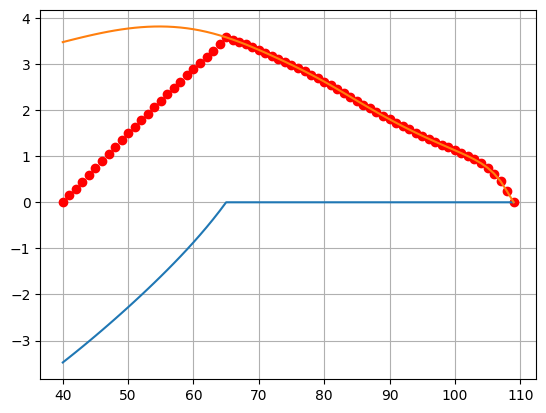

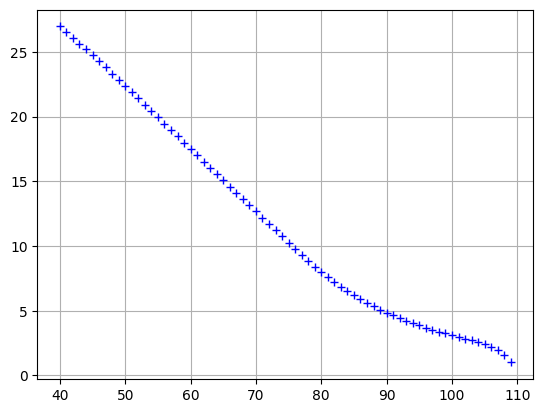

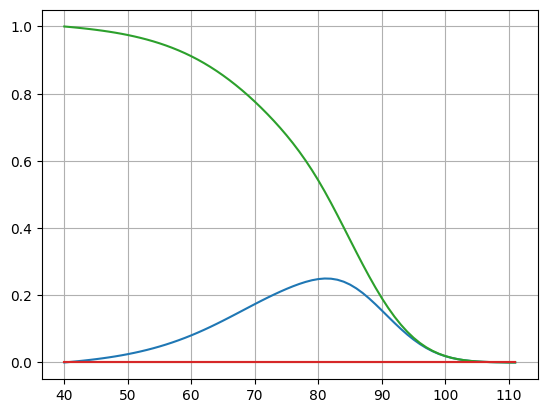

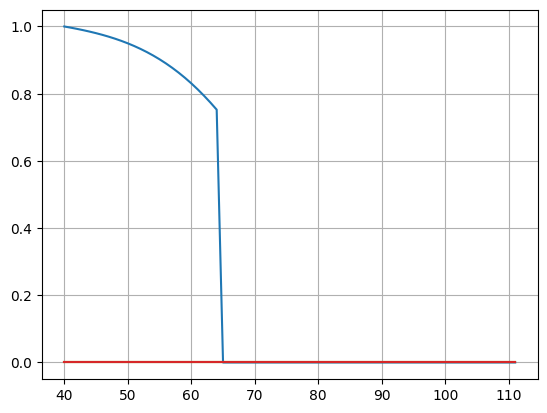

In [3]:
bAsk = True

print("Test Witenrente")

w = DK2(QxEK95)
w.psymR2 = ConstantBenefit
w.psymP12 = ConstantBenefit

gender1 = int(input("Gender 1 (0 ==> m male, 1 ==> female) "))
gender2 = int(input("Gender 2 (0 ==> m male, 1 ==> female) "))
x = int(input("Current Age x (40) ")) 
y = int(input("Current Age u (40) ")) 
sL = int(input("End Benefit age (110) "))
sP = int(input("End Premium Payment age (65) "))

w.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
y2=[]

for i in range(x,110):
    [PVL, PVP, PV] = w.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
    y2.append(PV[1])

plt.figure(1)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

plt.figure(2)
plt.plot(xPlot,y2,"b+")
plt.grid(True)

w.PlotCF(x)

Test Witenrente
[ 0.         25.28011532  2.30044677] [ 0.          0.         18.96051037]
Premium = 0.12132831463531984


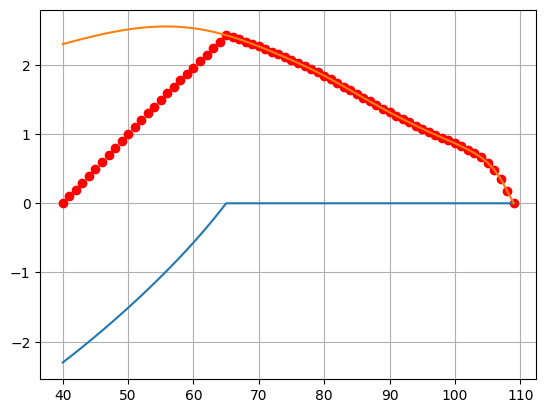

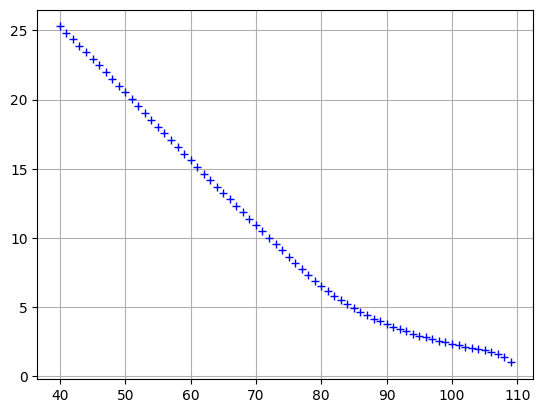

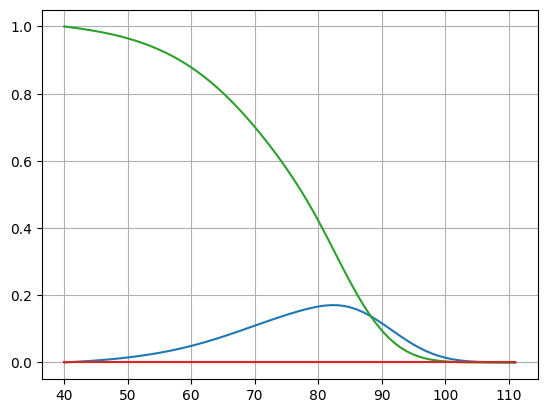

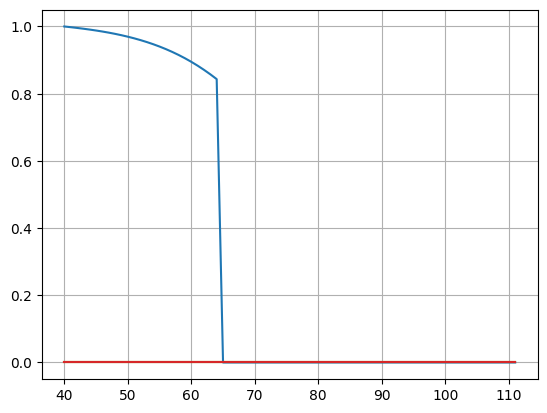

In [4]:
bAsk = True

print("Test Witenrente")

ww = DK2(QxEK95,QxLevelJoint = 0.60, QxLevelWidow = 1.40)
ww.psymR2 = ConstantBenefit
ww.psymP12 = ConstantBenefit

ww.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
y2=[]

for i in range(x,110):
    [PVL, PVP, PV] = ww.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
    y2.append(PV[1])

plt.figure(1)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

plt.figure(2)
plt.plot(xPlot,y2,"b+")
plt.grid(True)

ww.PlotCF(x)

Now the same for a symetrical widdow pension

Test Witenrente symetrical


Gender 1 (0 ==> m male, 1 ==> female)  1
Gender 2 (0 ==> m male, 1 ==> female)  1
Current Age x (40)  40
Current Age u (40)  40
End Benefit age (110)  80
End Premium Payment age (65)  60


[26.19060492 26.19060492  2.94416644] [ 0.          0.         16.12556867]
Premium = 0.18257752641948433


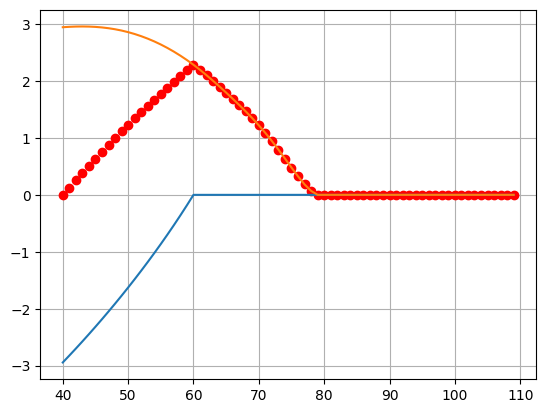

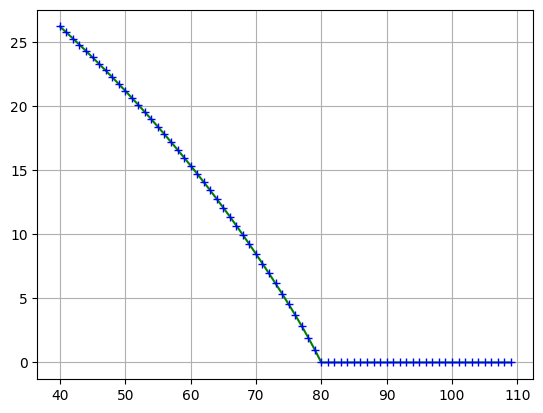

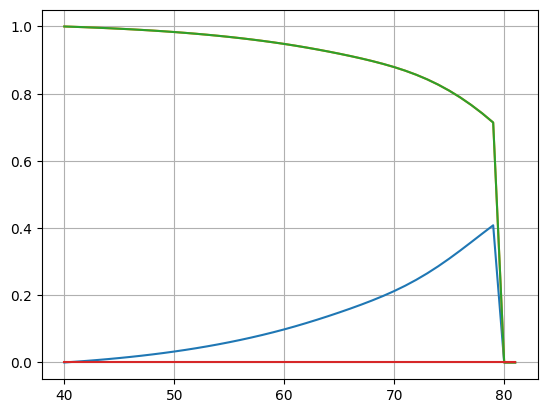

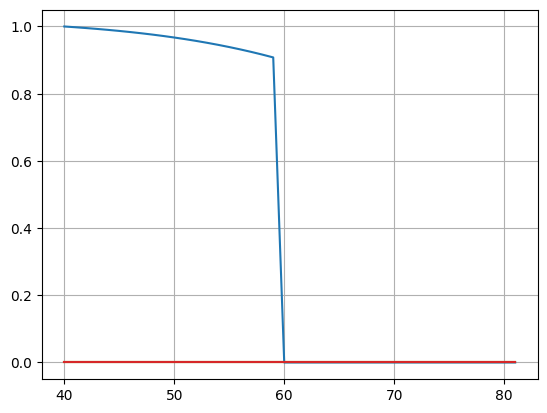

In [5]:
print("Test Witenrente symetrical")

ws = DK2(QxEK95)
ws.psymR1 = ConstantBenefit
ws.psymR2 = ConstantBenefit
ws.psymP12 = ConstantBenefit

if bAsk:
    gender1 = int(input("Gender 1 (0 ==> m male, 1 ==> female) "))
    gender2 = int(input("Gender 2 (0 ==> m male, 1 ==> female) "))
    x = int(input("Current Age x (40) ")) 
    y = int(input("Current Age u (40) ")) 
    sL = int(input("End Benefit age (110) "))
    sP = int(input("End Premium Payment age (65) "))

ws.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
y1=[]
y2=[]


for i in range(x,110):
    [PVL, PVP, PV] = ws.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
    y1.append(PV[0])
    y2.append(PV[1])

plt.figure(1)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

plt.figure(2)
plt.plot(xPlot,y1,"g-",xPlot,y2,"b+")
plt.grid(True)

ws.PlotCF(x)

***Mixed Endowment on joint life status***
We consider a Axy:n and assume that x=30, y = 27 and s = 65.
We would like to calculate the p
remium assuming that the premium is due until $s=65$.
In this case we have B12=M12=constant and P12=constant, rest equal 0. 

Joint Life Endowment


Gender 1 (0 ==> m male, 1 ==> female)  0
Gender 2 (0 ==> m male, 1 ==> female)  0
Current Age x (40)  40
Current Age u (40)  45
End Benefit age (110)  110
End Premium Payment age (65)  60


[0.         0.         0.49097842] [ 0.          0.         16.02999867]
Premium = 0.030628724809434085


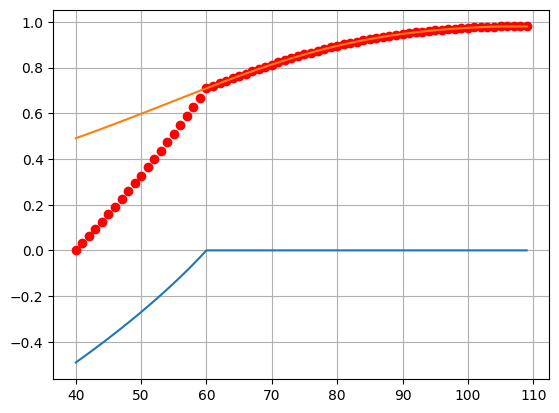

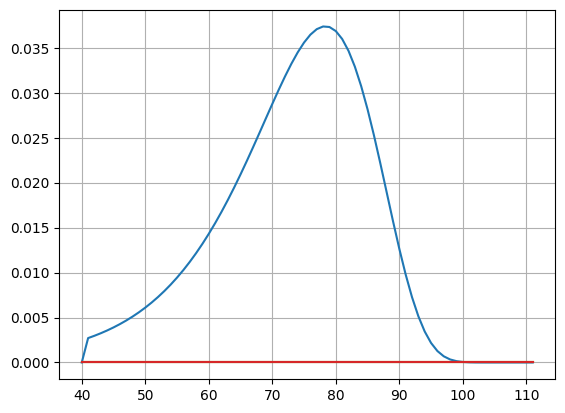

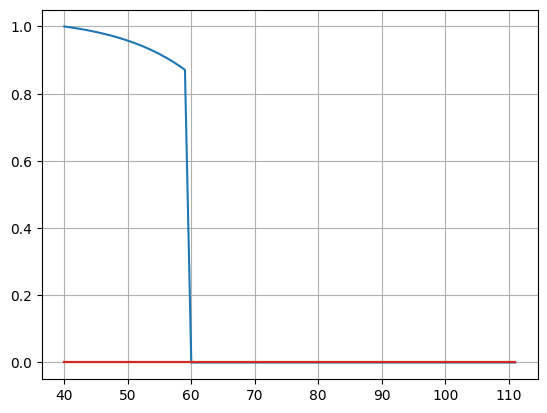

In [6]:
print("Joint Life Endowment")

axy = DK2(Qx)
axy.psymM12 = ConstantBenefit
axy.psymB12 = ConstantBenefit
axy.psymP12 = ConstantBenefit
if bAsk:
    gender1 = int(input("Gender 1 (0 ==> m male, 1 ==> female) "))
    gender2 = int(input("Gender 2 (0 ==> m male, 1 ==> female) "))
    x = int(input("Current Age x (40) ")) 
    y = int(input("Current Age u (40) ")) 
    sL = int(input("End Benefit age (110) "))
    sP = int(input("End Premium Payment age (65) "))

axy.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]

for i in range(x,sL):
    [PVL, PVP, PV] = axy.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(3)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

axy.PlotCF(x)

In [7]:
print(axy.psymLeist.symM.dPost[34])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Now the same for the joint status:

In [ ]:
print("Joint Life Endowment")

axybar = DK2(Qx)
axybar.psymM12 = ConstantBenefit
axybar.psymM2 = ConstantBenefit
axybar.psymM1 = ConstantBenefit
axybar.psymB12 = ConstantBenefit
axybar.psymB1 = ConstantBenefit
axybar.psymB2 = ConstantBenefit
axybar.psymP12 = ConstantBenefit
axybar.psymP1 = ConstantBenefit
axybar.psymP2 = ConstantBenefit

if bAsk:
    gender1 = int(input("Gender 1 (0 ==> m male, 1 ==> female) "))
    gender2 = int(input("Gender 2 (0 ==> m male, 1 ==> female) "))
    x = int(input("Current Age x (40) ")) 
    y = int(input("Current Age u (40) ")) 
    sL = int(input("End Benefit age (110) "))
    sP = int(input("End Premium Payment age (65) "))
axybar.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]
bTrace = False
for i in range(x,sL):
    [PVL, PVP, PV] = axybar.CalcPV(i,param=[])
    if bTrace:
        print("---- %d ----"%(i))
        print(PVL)
        print(PVP)
        print(PV)
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(4)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)
axybar.PlotCF(x)

Joint Life Endowment


Finally we look a a term insurance on the joint life until s=80 with premium payment until 65.

In [ ]:
print("Term Insurance")

axy1 = DK2(Qx)
axy1.psymB12 = ConstantBenefit
axy1.psymP12 = ConstantBenefit

if bAsk:
    gender1 = int(input("Gender 1 (0 ==> m male, 1 ==> female) "))
    gender2 = int(input("Gender 2 (0 ==> m male, 1 ==> female) "))
    x = int(input("Current Age x (40) ")) 
    y = int(input("Current Age u (40) ")) 
    sL = int(input("End Benefit age (110) "))
    sP = int(input("End Premium Payment age (65) "))

axy1.CalcPremium(gender1, gender2, x, y, sL, sP,param=[])

xPlot =[]
y12T=[]
y12P=[]
y12L=[]

for i in range(x,sL):
    [PVL, PVP, PV] = axy1.CalcPV(i,param=[])
    xPlot.append(i)
    y12T.append(PV[2])
    y12L.append(PVL[2])
    y12P.append(-PVP[2])
 
plt.figure(4)
plt.plot(xPlot,y12T,"ro",xPlot,y12P,xPlot,y12L)
plt.grid(True)

axy1.PlotCF(x)